# [LGR5 expressing skin fibroblasts define a major cellular hub perturbed in scleroderma](https://pubmed.ncbi.nlm.nih.gov/35381199/)
GEO: [GSE195452](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE195452)

In [16]:
source("R/install.R")

── R CMD build ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/tmp/Rtmp5XTUw6/remotes3c16475d427b2/SGDDNB-ShinyCell-6487126/DESCRIPTION’
─  preparing ‘ShinyCell’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘ShinyCell_2.1.0.tar.gz’
   


In [51]:
suppressPackageStartupMessages({
    library(Seurat)
    library(dplyr)
    library(readr)
    library(stringr)
    library(ShinyCell)
    library(Matrix)
    library(glmGamPoi)
    library(SingleR)
})

In [13]:
# Read in counts and convert to sparce matrix
tsv_files <- list.files(path = "data", pattern = "^GSM.*\\.txt\\.gz$", full.names = TRUE)
list_of_dfs <- lapply(tsv_files, function(file) {
  as(as.matrix(read.delim2(file)), "sparseMatrix")
})
save(list_of_dfs, file = file.path("object", "00.rda"))

In [21]:
# Merge sparce matrices
spar <- RowMergeSparseMatrices(list_of_dfs[[1]], list_of_dfs[-1])
save(spar, file = file.path("object", "01.rda"))

In [23]:
# Load metadata tables
meta1 <- read.delim2("metadata1.csv", sep = ",")%>%
  rename(
    PID = Sample_characteristics_ch1.2,
    Sample = Sample_title,
    Accession = Sample_geo_accession,
    Location = Sample_source_name_ch1,
    Tissue = Sample_characteristics_ch1,
    Marker = Sample_characteristics_ch1.1) %>%
  mutate(
    PID = str_remove(PID, "patient id: "),
    Tissue = str_remove(Tissue, "tissue: "),
    Marker = str_remove(Marker, "selection marker: "))

meta2 <- read.delim2("metadata2.csv", sep = ",")

annot <- read.delim2("GSE195452_Cell_metadata_v26_anno.txt")

In [35]:
# Join metadata tables
joined_df <- meta1 %>%
  inner_join(meta2, by = "PID")
  
mdata <- left_join(annot, joined_df, by = c("Amp_batch_ID" = "Sample")) %>%
    select(Well_ID, PID, Amp_batch_ID, Cell_barcode, annotation, Accession, Location, Tissue, Marker, Disease, Gender, Age, Skin_Score) %>% 
    na.omit()

rownames(mdata) <- mdata$Well_ID
mdata <- mdata[, -1, drop = FALSE]

head(mdata)

,PID,Amp_batch_ID,Cell_barcode,annotation,Accession,Location,Tissue,Marker,Disease,Gender,Age,Skin_Score
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>
WMC3988385,Ctrl060,AB13775,CTATTCG,_,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0
WMC3988386,Ctrl060,AB13775,ACTCAGG,Vascular_ACKR1,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0
WMC3988387,Ctrl060,AB13775,ACACGTG,Fibro_PTGDS,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0
WMC3988388,Ctrl060,AB13775,TCTTCGA,Fibro_LGR5,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0
WMC3988389,Ctrl060,AB13775,AGCACTG,_,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0
WMC3988390,Ctrl060,AB13775,AGTGCGT,Fibro_LGR5,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0


In [39]:
# Create Seurat with merged counts and metadata
obj <- CreateSeuratObject(counts = spar, meta.data =  mdata, assay = "RNA", min.cells = 3, min.features = 100)
obj <- subset(obj, PID != "NA")
obj[["percent.mt"]] <- PercentageFeatureSet(object = obj, pattern = "^MT-")
obj
save(obj, file = file.path("object", "02.rda"))

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Removing 90387 cells missing data for vars requested”


An object of class Seurat 
45022 features across 132368 samples within 1 assay 
Active assay: RNA (45022 features, 0 variable features)
 1 layer present: counts

In [40]:
head(obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,PID,Amp_batch_ID,Cell_barcode,annotation,Accession,Location,Tissue,Marker,Disease,Gender,Age,Skin_Score,percent.mt
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
WMC3988386,SeuratProject,1680,928,Ctrl060,AB13775,ACTCAGG,Vascular_ACKR1,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0,18.63095
WMC3988387,SeuratProject,1385,620,Ctrl060,AB13775,ACACGTG,Fibro_PTGDS,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0,28.23105
WMC3988388,SeuratProject,1917,939,Ctrl060,AB13775,TCTTCGA,Fibro_LGR5,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0,21.38758
WMC3988389,SeuratProject,752,375,Ctrl060,AB13775,AGCACTG,_,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0,35.37234
WMC3988390,SeuratProject,2098,1100,Ctrl060,AB13775,AGTGCGT,Fibro_LGR5,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0,19.44709
WMC3988391,SeuratProject,833,465,Ctrl060,AB13775,AACGTTC,Fibro_MYOC2,GSM5837114,Forearm skin,Skin,CD90+,Control,M,41,0,24.96999


In [44]:
obj <- SCTransform(obj, ncells = 3000,  variable.features.n = 2000, vst.flavor="v2", method = 'glmGamPoi', conserve.memory = TRUE)
save(obj, file=file.path("object", "03.rda"))

In [45]:
obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:20)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:20)
obj <- FindClusters(obj, resolution = 0.5)
obj
save(obj, file=file.path("object", "04.rda"))

PC_ 1 
Positive:  CD74, HLA-DRA, LYZ, HLA-DRB1, HLA-DPA1, CXCL8, HLA-DPB1, RNASE1, IL1B, S100A9 
	   S100A8, TMSB4X, B2M, SRGN, GNLY, HLA-DQB1, TYROBP, CTSS, MALAT1, CCL4 
	   CD83, IFI30, CCL3, HLA-B, CD52, GPR183, LCP1, AIF1, FCER1A, LAPTM5 
Negative:  COL1A1, COL1A2, DCN, COL3A1, CXCL14, SPARC, APOD, CFD, MMP2, SFRP2 
	   CCDC80, POSTN, MGP, FBLN1, COL6A1, LUM, GSN, FSTL1, COL6A2, CTSK 
	   CXCL12, PTGDS, MFAP5, VIM, C1R, C3, C1S, CFH, TIMP2, WISP2 
PC_ 2 
Positive:  CD74, HLA-DRA, CXCL8, RNASE1, LYZ, HLA-DRB1, COL1A1, HLA-DPA1, IL1B, FTL 
	   CST3, COL1A2, HLA-DPB1, COL3A1, FTH1, CCL3, CD83, C1QA, DCN, HLA-DQB1 
	   C1QB, S100A9, FCER1A, F13A1, CXCL2, GPR183, TYROBP, MRC1, IER3, MS4A6A 
Negative:  KRT1, KRT10, KRT5, KRT14, DMKN, DSP, KRTDAP, KRT2, PERP, LGALS7B 
	   DSG1, SFN, LY6D, DSC3, LGALS7, CALML5, SBSN, DSC1, S100A2, TRIM29 
	   RPLP1, SERPINB5, COL17A1, CASP14, FXYD3, LYPD3, SPINK5, CALML3, DAPL1, RPS6 
PC_ 3 
Positive:  GNLY, MALAT1, CCL5, NKG7, IL7R, TRBC2, IL32, CD52, PR

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 132368
Number of edges: 4279936

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9327
Number of communities: 24
Elapsed time: 67 seconds


An object of class Seurat 
83584 features across 132368 samples within 2 assays 
Active assay: SCT (38562 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



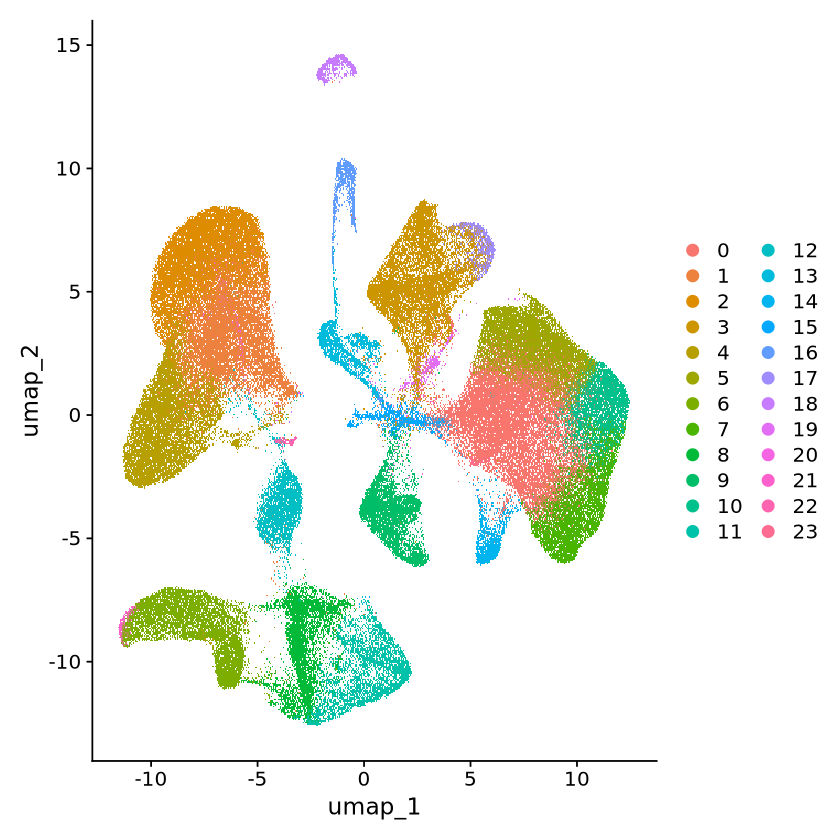

In [48]:
# Visualize
p1 <- DimPlot(obj)
p1

In [49]:
blueprint.ref <- celldex::BlueprintEncodeData()
monaco.ref <- celldex::MonacoImmuneData()

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache

see ?celldex and browseVignettes('celldex') for documentation

loading from cache



In [52]:
sce <- LayerData(obj)
blueprint.main <- SingleR(test = sce, assay.type.test = 1, ref = blueprint.ref, labels = blueprint.ref$label.main)
obj@meta.data$blueprint.main <- blueprint.main$pruned.labels
save(obj, file=file.path("object", "04.rda"))

In [53]:
table(obj@meta.data$blueprint.main)


       Adipocytes        Astrocytes           B-cells      CD4+ T-cells 
            20796               425              3994             11890 
     CD8+ T-cells      Chondrocytes                DC Endothelial cells 
            17723               853               583              1724 
      Eosinophils  Epithelial cells      Erythrocytes       Fibroblasts 
               96              1342               167             39435 
              HSC     Keratinocytes       Macrophages       Melanocytes 
             1368              2115              3000               197 
  Mesangial cells         Monocytes          Myocytes           Neurons 
               59             16987               292                33 
      Neutrophils          NK cells         Pericytes   Skeletal muscle 
               19              8137                17               705 
    Smooth muscle 
              411 

In [55]:
obj <- SetIdent(obj, value = "blueprint.main")
remove_low_count_cells <- function(seurat_obj, metadata_column, threshold = 20) {

  obj <- SetIdent(obj, value = metadata_column)

  total_counts <- table(seurat_obj@meta.data[[metadata_column]])

  low_count_cells <- names(total_counts[total_counts < threshold])

  seurat_obj <- subset(seurat_obj, idents = low_count_cells, invert = TRUE)

  return(seurat_obj)
}
obj <- remove_low_count_cells(seurat_obj = obj, metadata_column = "blueprint.main", threshold = 20)

In [56]:
table(obj@meta.data$blueprint.main)


       Adipocytes        Astrocytes           B-cells      CD4+ T-cells 
            20796               425              3994             11890 
     CD8+ T-cells      Chondrocytes                DC Endothelial cells 
            17723               853               583              1724 
      Eosinophils  Epithelial cells      Erythrocytes       Fibroblasts 
               96              1342               167             39435 
              HSC     Keratinocytes       Macrophages       Melanocytes 
             1368              2115              3000               197 
  Mesangial cells         Monocytes          Myocytes           Neurons 
               59             16987               292                33 
         NK cells   Skeletal muscle     Smooth muscle 
             8137               705               411 

In [57]:
obj <- SetIdent(obj, value = "blueprint.main")
obj <- subset(obj, idents = c("CD8+ T-cells", "B-cells", "CD4+ T-cells", "DC", "NK cells", "Macrophages", "Monocytes"), invert = FALSE)
table(obj@meta.data$blueprint.main)


     B-cells CD4+ T-cells CD8+ T-cells           DC  Macrophages    Monocytes 
        3994        11890        17723          583         3000        16987 
    NK cells 
        8137 

In [58]:
sce <- LayerData(obj)
monaco.fine <- SingleR(test = sce, assay.type.test = 1, ref = monaco.ref, labels = monaco.ref$label.fine)
obj@meta.data$monaco.fine <- monaco.fine$pruned.labels
save(obj, file=file.path('object', '05.rda'))

In [67]:
load(file=file.path('object', '05.rda'))

In [68]:
table(obj@meta.data$monaco.fine)


   Central memory CD8 T cells           Classical monocytes 
                         1477                          5616 
  Effector memory CD8 T cells             Exhausted B cells 
                          186                           109 
    Follicular helper T cells        Intermediate monocytes 
                          577                          3238 
        Low-density basophils       Low-density neutrophils 
                          257                             5 
                   MAIT cells       Myeloid dendritic cells 
                         1893                          8083 
                Naive B cells             Naive CD4 T cells 
                         2327                           716 
            Naive CD8 T cells          Natural killer cells 
                         3087                          4459 
      Non classical monocytes   Non-switched memory B cells 
                         2360                           459 
           Non-Vd2 gd T

In [69]:
obj <- SetIdent(obj, value = "monaco.fine")
remove_low_count_cells <- function(seurat_obj, metadata_column, threshold = 20) {

  obj <- SetIdent(obj, value = metadata_column)

  total_counts <- table(seurat_obj@meta.data[[metadata_column]])

  low_count_cells <- names(total_counts[total_counts < threshold])

  seurat_obj <- subset(seurat_obj, idents = low_count_cells, invert = TRUE)

  return(seurat_obj)
}
obj <- remove_low_count_cells(seurat_obj = obj, metadata_column = "monaco.fine", threshold = 20)

In [70]:
table(obj@meta.data$monaco.fine)


   Central memory CD8 T cells           Classical monocytes 
                         1477                          5616 
  Effector memory CD8 T cells             Exhausted B cells 
                          186                           109 
    Follicular helper T cells        Intermediate monocytes 
                          577                          3238 
        Low-density basophils                    MAIT cells 
                          257                          1893 
      Myeloid dendritic cells                 Naive B cells 
                         8083                          2327 
            Naive CD4 T cells             Naive CD8 T cells 
                          716                          3087 
         Natural killer cells       Non classical monocytes 
                         4459                          2360 
  Non-switched memory B cells            Non-Vd2 gd T cells 
                          459                          2329 
                 Plasma

In [71]:
save(obj, file=file.path('object', '05.rda'))

In [85]:
load(file=file.path('object', '05.rda'))
obj <- subset(obj, subset = Tissue == "Skin")
obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:20)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:20)
obj <- FindClusters(obj, resolution = 0.5)

# Select needed columns
columns_to_keep <-  c('orig.ident', 'PID', 'Location', 'Marker', 'Disease', 'Gender', 'Age', 'Skin_Score', 'blueprint.main', 'monaco.fine')
obj@meta.data <- obj@meta.data[, columns_to_keep, drop = FALSE]

save(obj, file=file.path('object', 'skin.rda'))

PC_ 1 
Positive:  DCN, COL1A1, COL1A2, CXCL14, COL3A1, APOD, SPARC, CFD, MGP, IGFBP7 
	   CCDC80, ACTA2, CXCL12, RGS5, GNLY, MMP2, SPARCL1, FBLN1, MALAT1, COL6A1 
	   POSTN, C3, TIMP3, IFITM1, C1S, CFH, GSN, LUM, C1R, KRT14 
Negative:  CD74, HLA-DRA, CXCL8, RNASE1, HLA-DRB1, IL1B, HLA-DPA1, HLA-DPB1, CCL3, CST3 
	   CD83, HLA-DQB1, GPR183, FCER1A, C1QA, FTL, CXCL2, IER3, C1QB, CCL4 
	   LYZ, MRC1, FOSB, HLA-DQA1, F13A1, HLA-DRB5, FTH1, CCL3L3, SRGN, NR4A3 
PC_ 2 
Positive:  RNASE1, C1QA, C1QB, F13A1, LYVE1, CCL13, LGMN, FTL, FOLR2, MRC1 
	   CD14, CD163, SELENOP, DAB2, PLTP, LILRB5, MS4A4A, CD209, C1QC, CTSC 
	   SLC40A1, VSIG4, STAB1, FCGRT, MPEG1, GGTA1P, AC025857.2, CSF1R, MARCO, CCL18 
Negative:  IL1B, FCER1A, HLA-DRA, HLA-DPB1, HLA-DRB1, HLA-DPA1, LYZ, CXCL8, HLA-DQB1, G0S2 
	   CD74, CD1C, GPR183, HLA-DQA1, BCL2A1, RGS1, DUSP2, NR4A3, SRGN, HLA-DQB2 
	   CCL4L2, CD83, INSIG1, CXCR4, PLAUR, IL1R2, HLA-DRB5, IL1RN, CCL4, PTGS2 
PC_ 3 
Positive:  TPSB2, TPSAB1, CCL4, CXCL8, CPA3, CC

In [ ]:
seu =  obj
scConf1 = createConfig(seu)
makeShinyFiles(seu, scConf1,
             gene.mapping = TRUE,
             shiny.prefix = "sc1",
             shiny.dir = "sclerosis_LGR5_scRNA-seq_GSE195452/",
             gex.assay = "SCT",
             default.multigene = c('LILRB1', 'PDCD1')) 

ID,UI,fID,fCL,fRow,grp,dimred
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
orig.ident,orig.ident,SeuratProject,black,1,FALSE,FALSE
nCount_RNA,nCount_RNA,NA,NA,NA,FALSE,FALSE
nFeature_RNA,nFeature_RNA,NA,NA,NA,FALSE,FALSE
annotation,annotation,_|B|B_CXCR4|DC|DC_CCL22|DC_CXCL10|DC_XCR1|KRT1_KRT10|LC|M_CD16_IL1B|M_IL1B|Mast|Mast_CLC|Mf|Mf_TREM2|Mo|Mo_CD16|NK|NK_XCL1|NK_XCL1_CXCR4|pDC|pDC_CXCR4|Peri_TGFBI|Plasma|sT|sT_Effector|sTreg|sTreg_CXCR4|T_Effector|T_GD|T_Naive|Treg|UN|Vascular_ACKR1|Vascular_RBP7,#A6CEE3|#7AB2D3|#4E96C4|#227AB5|#4A96A7|#79B79A|#A9D88C|#90CE71|#67B952|#3EA534|#629E45|#A29C68|#E39A8C|#F67F7F|#EE5656|#E62C2E|#E7372A|#F06C45|#F8A160|#FDB55E|#FDA03A|#FE8C16|#F88519|#E7955E|#D6A5A3|#C1A7D0|#A281BD|#835BA9|#724899|#A28799|#D3C599|#FCFA95|#E3C471|#CA8E4C|#B15928,9,TRUE,FALSE
Location,Location,Forearm skin|Leg skin,#A6CEE3|#B15928,1,TRUE,FALSE
Tissue,Tissue,Skin,black,1,FALSE,FALSE
Marker,Marker,B2M+|CD45+|CD45+CD90+|CD90-CD45-|CD90+|CD90+LGR5+DPP4+|Peri_Vas,#A6CEE3|#99CD91|#B89B74|#F06C45|#ED8F47|#825D99|#B15928,2,TRUE,FALSE
Disease,Disease,Control|SSC,#A6CEE3|#B15928,1,TRUE,FALSE
Gender,Gender,F|M,#A6CEE3|#B15928,1,TRUE,FALSE


In [ ]:
load(file=file.path('object', '05.rda'))
obj <- subset(obj, subset = Tissue == "Blood")
obj <- RunPCA(obj, npcs = 30, verbose = TRUE)
obj <- RunUMAP(obj, reduction = "pca", dims = 1:20)
obj <- FindNeighbors(obj, reduction = "pca", dims = 1:20)
obj <- FindClusters(obj, resolution = 0.5)

# Select needed columns
columns_to_keep <-  c('orig.ident', 'PID', 'Location', 'Marker', 'Disease', 'Gender', 'Age', 'Skin_Score', 'blueprint.main', 'monaco.fine')
obj@meta.data <- obj@meta.data[, columns_to_keep, drop = FALSE]

save(obj, file=file.path('object', 'blood.rda'))

PC_ 1 
Positive:  DCN, COL1A1, COL1A2, CXCL14, COL3A1, APOD, SPARC, CFD, MGP, IGFBP7 
	   CXCL12, CCDC80, GSN, ACTA2, RGS5, VIM, RNASE1, MMP2, HSPA1A, PTGDS 
	   SNORD100, C3, SPARCL1, SERPING1, POSTN, FBLN1, KRT14, CCL2, TIMP3, COL6A1 
Negative:  S100A9, LYZ, S100A8, FCN1, CTSS, S100A12, IFI30, VCAN, TYROBP, MNDA 
	   SERPINA1, CYBB, FTL, AIF1, PLBD1, FCER1G, LST1, ACTB, FGR, COTL1 
	   MPEG1, ITGB2, PSAP, NCF2, AC134669.2, FCGR3A, LAPTM5, CD74, CD14, LILRB2 
PC_ 2 
Positive:  DCN, COL1A1, COL1A2, CXCL14, COL3A1, APOD, LYZ, VIM, S100A9, S100A8 
	   SPARC, MT-RNR1, CFD, CST3, MGP, FTL, IGFBP7, CXCL12, S100A6, FTH1 
	   GSN, CCDC80, ACTA2, HSPA1A, RGS5, RNASE1, MMP2, SERPING1, C3, IFITM3 
Negative:  GNLY, MALAT1, CCL5, NKG7, IL7R, PRF1, CD52, B2M, TRBC2, LTB 
	   GIMAP7, GZMA, TCF7, RPLP2, CST7, AC245427.1, KLRD1, RPS3, TRAC, SNORD100 
	   RPS12, RPS29, GZMB, IGHM, SNORA31, HLA-B, RPS15A, RPS6, GZMH, FCMR 
PC_ 3 
Positive:  IGKC, IGHM, IGLC2, CD74, IGLC1, MS4A1, CD79A, LTB, IL7R, IGLC3 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 37339
Number of edges: 1241200

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8817
Number of communities: 12
Elapsed time: 8 seconds


In [ ]:
seu =  obj
scConf2 = createConfig(seu)
makeShinyFiles(seu, scConf2,
             gene.mapping = TRUE,
             shiny.prefix = "sc2",
             shiny.dir = "sclerosis_LGR5_scRNA-seq_GSE195452/",
             gex.assay = "SCT",
             default.multigene = c('LILRB1', 'PDCD1')) 

ID,UI,fID,fCL,fRow,grp,dimred
<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
orig.ident,orig.ident,SeuratProject,black,1,FALSE,FALSE
nCount_RNA,nCount_RNA,NA,NA,NA,FALSE,FALSE
nFeature_RNA,nFeature_RNA,NA,NA,NA,FALSE,FALSE
annotation,annotation,_|B|B_CXCR4|DC|DC_CCL22|DC_CXCL10|DC_XCR1|KRT1_KRT10|M_CD16_IL1B|M_IL1B|Mast|Mast_CLC|Mf|Mf_TREM2|Mo|Mo_CD16|NK|NK_XCL1|NK_XCL1_CXCR4|pDC|pDC_CXCR4|Plasma|sT|sT_Effector|sTreg|sTreg_CXCR4|T_Effector|T_GD|T_Naive|Treg|UN,#A6CEE3|#74AED1|#438EC0|#2D82AF|#63A8A0|#99CD91|#98D277|#6ABB54|#3BA432|#6E9E4C|#B89B74|#FA9594|#F16667|#E83739|#E62F27|#F06C45|#F9A963|#FDB055|#FE982C|#FE8103|#ED8F47|#D9A295|#C3AAD2|#A07FBC|#7D54A5|#825D99|#B9A499|#F0EB99|#EAD27A|#CD9551|#B15928,8,TRUE,FALSE
Location,Location,Peripheral blood,black,1,FALSE,FALSE
Tissue,Tissue,Blood,black,1,FALSE,FALSE
Marker,Marker,CD14+CD16+|CD45+|NONB/T,#A6CEE3|#F06C45|#B15928,1,TRUE,FALSE
Disease,Disease,Control|SSC,#A6CEE3|#B15928,1,TRUE,FALSE
Gender,Gender,F|M,#A6CEE3|#B15928,1,TRUE,FALSE


In [ ]:
citation = list(
  author  = "Liu X., Ouyang J.F., Rossello F.J. et al.",
  title   = "",
  journal = "Cell",
  volume  = "185",
  page    = "1373-1388",
  year    = "2022", 
  doi     = "10.1016/j.cell.2022.03.011",
  link    = "https://pubmed.ncbi.nlm.nih.gov/35381199/")
makeShinyCodesMulti(
  shiny.title = "Systemic Sclerosis LRG5 Expression scRNAseq", shiny.footnotes = citation,
  shiny.prefix = c("sc1", "sc2"),
  shiny.headers = c("Skin", "Blood"), 
  shiny.dir = "sclerosis_LGR5_scRNA-seq_GSE195452/") 

In [ ]:
system("R -e \"shiny::runApp('sclerosis_LGR5_scRNA-seq_GSE195452')\"")